# Deep Learning & Applied AI

# Tutorial 4: Logistic Regression and Optimization

In this tutorial, we will cover:

- Logistic regression
- Optimization, parameters tuning, weight decay, learning rate decay, energy landscape

Our info:

- Dr. Luca Moschella (moschella@di.uniroma1.it)
- Dr. Donato Crisostomi (crisostomi@di.uniroma1.it)

Course:

- Website and notebooks will be available at [DLAI-s2-2022](https://erodola.github.io/DLAI-s2-2022/)

# Imports and utilities

In [ ]:
# @title import dependencies

from typing import Mapping, Union, Optional

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import torchvision

from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [ ]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

In [ ]:
# @title utility non-convex functions

from typing import Callable, Union, Sequence
import math

def peaks(xx: torch.Tensor, yy: torch.Tensor) -> torch.Tensor:
  """ 
  "Peaks" function that has multiple local minima.
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  return (0.25 * (3*(1-xx)**2*torch.exp(-xx**2 - (yy+1)**2) - 
                  10*(xx/5 - xx**3 - yy**5)*torch.exp(-xx**2-yy**2) - 
                  1/3*torch.exp(-(xx+1)**2 - yy**2)))

def rastrigin(xx: torch.Tensor, yy: torch.Tensor, shift: int = 0) -> torch.Tensor:
  """ 
  "Rastrigin" function with `A = 3` 
  https://en.wikipedia.org/wiki/Rastrigin_function
  """
  xx = torch.as_tensor(xx) 
  yy = torch.as_tensor(yy) 
  A = 3
  return A * 2 + (((xx - shift) ** 2 - A * torch.cos(2 * torch.tensor(math.pi, dtype=torch.float, device=xx.device) * xx))
                  +
                  ((yy - shift) ** 2 - A * torch.cos(2 * torch.tensor(math.pi, dtype=torch.float, device=xx.device) * yy)))

def rosenbrock(xx: torch.Tensor, yy: torch.Tensor) -> torch.Tensor:
  """
  "Rosenbrock" function
  https://en.wikipedia.org/wiki/Rosenbrock_function

  It has a global minimum at $(x , y) = (a, a^2) = (1, 1)$
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  
  a = 1
  b = 100
  return (a - xx) ** 2 + b * (yy - xx**2)**2

In [ ]:
# @title utility plot functions


def plot_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    autoshow: bool = False,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    **kwargs
) -> go.Figure:
    """ Plot the landscape defined by the function `fn`.

    Creates a domain grid $x,y \in R^2$ with $x \in [-lim, lim]$ and
    $y \in [-lim, lim]. The number of points in this grid is resolution**2.
    """
    xx = torch.linspace(-lim, lim, resolution)
    yy = torch.linspace(-lim, lim, resolution)
    zz = fn(xx[None, :], yy[:, None], **kwargs)

    xx = xx.cpu().detach()
    yy = yy.cpu().detach()
    zz = zz.cpu().detach()

    fig = go.Figure(data=[go.Surface(z=zz, x=xx, y=yy, opacity=landscape_opacity)])
    fig.update_traces(
        contours_z=dict(
            show=True, usecolormap=True, highlightcolor="lightgray", project_z=True
        )
    )
    fig.update_layout(
        title=f"{fn.__name__.title()} landscape" if title is None else title,
        height=height,
        scene=dict(
            xaxis_title=xaxis_title, 
            yaxis_title=yaxis_title, 
            zaxis_title=f"{fn.__name__}(x, y)" if zaxis_title is None else zaxis_title,
        ),
    )

    if autoshow:
      fig.show()
    return fig


def plot_point_over_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    point: (float, float) = None,
    resolution: int = 100,
    lim: int = 3,
    landscape_opacity: float = 1.0,
    height: int = 900,
    title: Optional[str] = None,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    autoshow: bool = False,
) -> go.Figure:
    """ Plot a point over the landascape defined by the cunction `fn`

  :param fn: an universal function $R^2 -> R$
  :param point: if not None, marks the point with a red dot
  :param title: the title of the plots, if None defaults to  the fn name
  :param autoshow: if True, calls fig.show() before returning the figure

  :retuns: the figure that contains the plot
  """
    fig = plot_landscape(
        fn,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=landscape_opacity,
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        zaxis_title=zaxis_title,
    )

    # Create starting path
    x_point, y_point = (float(p) for p in point)
    fig.add_trace(
        go.Scatter3d(
            visible=True,
            showlegend=False,
            mode="markers",
            marker=dict(size=6, color="white", symbol="circle"),
            x=[x_point],
            y=[y_point],
            z=[fn(x_point, y_point).cpu().detach()],
        )
    )

    if autoshow:
        fig.show()

    return fig


# awesome functions 👀


def plot_path_over_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    x_path: Union[torch.Tensor, Sequence[float]],
    y_path: Union[torch.Tensor, Sequence[float]],
    global_minimum: (float, float) = None,
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    autoshow: bool = False,
) -> go.Figure:
    """ Plot a path over the landascape defined by the cunction `fn`

  :param fn: an universal function $R^2 -> R$ (must support broadcasting between x, y)
  :param x_path: the x coordinate of each point in the path
  :param y_path: the y coordinate of each point in the path
  :param global_minimum: if not None, marks the point with a red dot
  :param resolution: the resolution of the R^2 domain
  :param lim: the limits of the R^2 domain (symmetric around 0 in x and y)
  :param height: the height of the figure
  :param landscape_opacity: the landscape plot opacity
  :param title: the title of the plots, if None defaults to  the fn name
  :param autoshow: if True, calls fig.show() before returning the figure

  :retuns: the figure that contains the plot
  """
    fig = plot_landscape(
        fn,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=landscape_opacity,
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        zaxis_title=zaxis_title,
    )

    x_path = torch.as_tensor(x_path, dtype=torch.float)
    y_path = torch.as_tensor(y_path, dtype=torch.float)
    z_path = fn(x_path, y_path)

    # Create starting path
    fig.add_trace(
        go.Scatter3d(
            visible=True,
            showlegend=False,
            marker=dict(size=4, color="white", symbol="circle"),
            line=dict(color="lightgray", width=3),
            x=x_path[0:1],
            y=y_path[0:1],
            z=z_path[0:1],
        )
    )
    # If you discover how to project the path into the landscape contour, tell me! :]

    if global_minimum is not None:
        x_point, y_point = (float(p) for p in global_minimum)

        # Create the goal marker
        fig.add_trace(
            go.Scatter3d(
                visible=True,
                showlegend=False,
                mode="markers",
                marker=dict(size=3, color="red", symbol="circle"),
                x=[x_point],
                y=[y_point],
                z=[fn(x_point, y_point).cpu().detach()],
            )
        )

    # Create frames that modify the starting path
    frames = []
    for j in np.arange(1, z_path.shape[0]):
        frames.append(
            go.Frame(
                name=f"frame{j}",
                traces=[1],
                data=[go.Scatter3d(x=x_path[:j], y=y_path[:j], z=z_path[:j],)],
            )
        )

    # Create the slider to start the animation at different timesteps
    sliders = [
        dict(
            steps=[
                dict(
                    method="animate",  # Sets the Plotly method to be called when the
                    # slider value is changed.
                    args=[
                        [f"frame{k}"],  # Sets the arguments values to be passed to
                        # the Plotly method set in method on slide
                        dict(
                            mode="immediate",
                            frame=dict(duration=50, redraw=False),
                            transition=dict(duration=0),
                        ),
                    ],
                    label=f"{k}",
                )
                for k in range(z_path.shape[0] - 1)
            ],
            currentvalue={"prefix": "Iteration: "},
        )
    ]
    # If you find out how to fix the slider let me know :]

    fig["layout"]["sliders"] = sliders
    fig["layout"]["updatemenus"] = [
        dict(
            type="buttons",
            pad={"r": 10, "t": 70},
            showactive=False,
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=500, redraw=True),
                            transition=dict(duration=0),
                            fromcurrent=True,
                            mode="immediate",
                        ),
                    ],
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[[None], dict(mode="immediate")],
                ),
            ],
        )
    ]

    fig["frames"] = frames

    if autoshow:
        fig.show()

    return fig


def plot_optimization(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    start: (float, float),
    opt: torch.optim.Optimizer,
    opt_args: Mapping[str, Union[float, str]],
    n_steps: int = 50,
    goal: (float, float) = None,
    device: Optional[str] = None,
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    autoshow: bool = False,
) -> go.Figure:
    """
    Run an optimization process and plot the optimization path

    :param fn: an universal function $R^2 -> R$ (must support broadcasting between x, y)
    :param start: the starting point to optimize
    :param opt: the optimizer to use
    :param opt_args: the arguments to use for the current optimizers
    :param n_steps: the number of steps to perform in this optimization process
    :param goal: if not None, mark the point that represents the goal of the optimization
    :param device: the device to use, if None defaults to 'cuda' if available
    :param resolution: the resolution of the R^2 domain
    :param lim: the limits of the R^2 domain (symmetric around 0 in x and y)
    :param height: the height of the figure
    :param landscape_opacity: the landscape plot opacity
    :param title: the title of the plots, if None defaults to  the fn name

    :param autoshow: if True, calls fig.show() before returning the figure

    :returns: the figure with the landscape and the optimization path
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    x = torch.tensor(start[0], device=device, dtype=torch.float, requires_grad=True)
    y = torch.tensor(start[1], device=device, dtype=torch.float, requires_grad=True)
    x_line = [x.cpu().detach().item()]
    y_line = [y.cpu().detach().item()]

    opt = opt([x, y], **opt_args)

    for i in tqdm(range(n_steps), desc="Optimization"):
        out = fn(x, y)
        out.backward()
        opt.step()
        opt.zero_grad()
        x_line.append(x.item())
        y_line.append(y.item())

    f = plot_path_over_landscape(
        fn,
        x_line,
        y_line,
        global_minimum=goal,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=1,
        title=title,
        autoshow=autoshow,
    )
    return f


# Logistic Regression

### Classifying handwritten digits
Today we start with the *Hello world!* of deep learning, classifying MNIST digits using logistic regression.

## Data loading

Let's download the dataset from the website of Yann LeCun using torchvision.

In [ ]:
# Here we are using a mirror for the official MNIST website
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-03-22 20:52:03--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-03-22 20:52:04--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [        <=>         ]  33.20M  20.9MB/s    in 1.6s    

2022-03-22 20:52:06 (20.9 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [ ]:
train_dataset = datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       # tranforming images to pytorch tensors                          
                       transforms.ToTensor(),  

                       # normalizing the tensors, i.e. the distribution of values on each sample should have mean=0.1307 and stddev=0.3081,
                       # corresponding to the mean and stddev of the whole MNIST dataset. 
                       # Check https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current 
                       # for an intuition.
                       transforms.Normalize((0.1307,), (0.3081,))  
                   ])
                )

test_dataset = datasets.MNIST('./', train=False, 
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
                )

## Data exploration

It is always a good idea to look at some entries in the dataset.

In [ ]:
import plotly.express as px
import numpy as np

mnist_example = train_dataset[42][0][0].numpy()
print('A MNIST sample has size', mnist_example.shape)
fig = px.imshow(mnist_example)
fig.show()

A MNIST sample has size (28, 28)


**Is this a 1 or a 7?**

This is the existential question we will try to answer today.

So we need to select only the 1 and 7 samples from the MNIST dataset





In [ ]:
for dataset in [train_dataset, test_dataset]:
    mask_sevens = dataset.targets == 7 
    mask_ones = dataset.targets == 1

    # re-map 7s to have label 0 and 1s to have label 1
    dataset.targets[mask_sevens] = 0  
    dataset.targets[mask_ones] = 1
    
    # only keep 7s and 1s
    dataset.targets = dataset.targets[mask_sevens + mask_ones]
    dataset.data = dataset.data[mask_sevens + mask_ones]

In [ ]:
# We could work only with dataset class in this tutorial, but let's get used to the Pytorch DataLoader.
# Notice that with batch_size=len(dataset), the item yielded by these DataLoaders is the full dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)


How difficult is this task? 

>It is always important to have an idea of how much *intelligence* you do expect from your AI application.

How can you make that estimate? Often a simple solution is at your fingertips...

>**EXERCISE (warm-up)**: Combine several samples in a grid and plot a big picture. Then try to classify each one as a 1 or a 7. What is your classification accuracy?

Even the best spend their time classifying images by hand... ([Imagenet and Andrej Karpathy](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/), director of AI at Tesla).


In [ ]:
# ✏️ your code here
# hint: use `torchvision.utils.make_grid` and `px.imshow`

images = next(iter(train_dataloader))
# ...


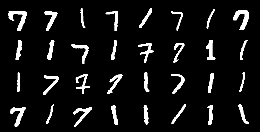

In [ ]:
# @title Solution  { run: "auto" }

cols = 8  #@param {type:"slider", min:1, max:8, step:1}
rows = 4 #@param {type:"slider", min:1, max:4, step:1}

grid_images = images[0][:rows*cols, ...]
resolved_grid = torchvision.utils.make_grid(grid_images, padding=4, nrow=cols, normalize=True, value_range=(0, 1))
px.imshow(resolved_grid.permute(1, 2, 0))

## Building the model

Given a dataset $(\mathbf{X}, \mathbf{t})$  with $\mathbf{X} \in \mathbb{R}^{N \times k}$ and $\mathbf{t} \in [0,1]^N$, the prediction of a logistic regression model $f_\theta$, with $\theta = \{\mathbf{a}, b\}$, on a sample $\mathbf{x}_i$ is:
$$f_\theta(\mathbf{x}_i) = \sigma(\mathbf{a}^T\mathbf{x}_i + b)$$

Such predictions are evaluated by a cross-entropy error:
$$ E(\theta) = - \frac{1}{N}\sum_{i=1}^N t_i \ln(f_\theta(\mathbf{x}_i)) + (1 - t_i)\ln(1 - f_\theta(\mathbf{x}_i)) $$

Which we are going to minimize following the opposite direction of the gradient of $E(\theta)$, starting from an initial configuration $\theta_0$.

$$\nabla E(\theta) = (\frac{\partial E}{\partial a_1}, \frac{\partial E}{\partial a_2}, ... , \frac{\partial E}{\partial a_k}, \frac{\partial E}{\partial b})$$

Notice that logistic regression works with 1-dimensional vectors. With great reluctance we have to destroy the natural domain where our data live, i.e. $\mathbb{R}^2$, flattening each sample to $\mathbb{R}^1$.

[With great reluctance](https://i.pinimg.com/originals/bd/a5/ef/bda5ef59a353d077c07a2f154f9c595a.jpg) because simple 2D patterns may become very intricate in 1D, making learning harder. 
![polyfit matrix notation](https://drive.google.com/uc?export=view&id=1uPlydRr82rgjd7pr04aBXl8SwEgrwK7I)

Let's compute the prediction of our logistic regression model and the gradient $\nabla E(\theta)$ for a set of samples $\mathbf{X}$.

>**EXERCISE**: complete the function.

In [ ]:
# ✏️ your code here

def lr_prediction_and_gradients(theta, X, t):
    """
    Logistic regression prediction and gradients on MNIST
    Arguments:
    theta -- parameters, a torch tensor of size (28 * 28 + 1), the last is the bias
    X -- data, a torch tensor of size (number of examples, 28, 28)
    t -- true "label" vector (containing 0 if seven, 1 if one), a torch tensor of size (number of examples)

    Return:
    loss -- negative log-likelihood loss, a torch tensor of size (1)
    dtheta -- gradient of the loss with respect to theta, a torch tensor of size (28 * 28 + 1)
    pred -- model predictions, a torch tensor of size (number of examples)
    """



    # Prediction (from X to loss)
    # hint: add a column of ones to X to manage the bias


    # Gradients

    assert(dtheta.shape == theta.shape)
    
    return loss, dtheta, pred


# # testing the function, you should obtain loss = 1.127, torch.sum(gradient) = 57.592
# X, t = next(iter(train_dataloader)) 
# theta = torch.ones(28*28+1) / 100

# loss, gradient, _ = lr_prediction_and_gradients(theta, X, t)
# print('loss:', loss, 'gradient:', torch.sum(gradient))

> [Math hint](https://medium.com/mathematics-behind-optimization-of-cost-function/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d)  👀 

In [ ]:
# @title Solution 👀

def lr_prediction_and_gradients(theta, X, t):
    """
    Logistic regression prediction and gradients on MNIST
    Arguments:
    theta -- parameters, a torch tensor of size (28 * 28 + 1), the last is the bias
    X -- data, a torch tensor of size (number of examples, 28, 28)
    t -- true "label" vector (containing 0 if seven, 1 if one), a torch tensor of size (number of examples)

    Return:
    loss -- negative log-likelihood loss, a torch tensor of size (1)
    dtheta -- gradient of the loss with respect to theta, a torch tensor of size (28 * 28 + 1)
    pred -- model predictions, a torch tensor of size (number of examples)
    """
    
    N = X.shape[0]
    X = X.reshape(N, -1)

    # Prediction (from X to loss)
    # hint: add a column of ones to X to manage the bias
    new_X = torch.cat((X, torch.ones((N, 1))), dim=1)
    pred = torch.sigmoid(torch.einsum('i,ji->j', theta, new_X))
    loss = (- 1 / N) * torch.sum(t * torch.log(pred) + (1 - t) * (torch.log(1 - pred)))

    # Gradients
    dtheta = (1 / N) * torch.einsum('ji,j->i', new_X, pred - t)

    assert(dtheta.shape == theta.shape)
    
    return loss, dtheta, pred


# testing the function, you should obtain loss = 1.127, torch.sum(gradient) = 57.592
X, t = next(iter(train_dataloader)) 
theta = torch.ones(28*28+1) / 100

loss, gradient, _ = lr_prediction_and_gradients(theta, X, t)
print('loss:', loss, 'gradient:', torch.sum(gradient))

loss: tensor(1.1268) gradient: tensor(57.5922)


####Optimizing the model

We will search the optimal $\theta$ through naive gradient descent (GD, $m = N$) and stochastic gradient descent (SGD, $m < N$).
$$\theta^{(t+1)} = \theta^{(t)} - \alpha \nabla E(\theta^{(t)})$$
with
$$\nabla E(\theta^{(t)}) = \frac{1}{m} \sum_i^m \nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\}) $$

Let's play with two relevant parameters of the optimization:
- the batch size $m$. 
- the number of *epochs*, i.e. $ \frac{\text{how many }\nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\}) \text{ we compute}}{N} $  (A single step of naive GD is an epoch!)

Why small batch trends are so noisy?

In [ ]:
# @title Logistic regression: epochs and batch_size { run: "auto" }

num_epochs = 10  #@param {type:"slider", min:1, max:20, step:1}
batch_size_1 = "500"  #@param ["1", "2", "3", "5", "10", "50", "100", "500", "1000", "6500", "13007"]
batch_size_2 = "13007"  #@param ["1", "2", "3", "5", "10", "50", "100", "500", "1000", "6500", "13007"]
plot_log_scale = False  #@param {type:"boolean"}

learning_rate = 0.01
theta_init = torch.randn(28*28+1) / 100

X, t = next(iter(train_dataloader)) 
X_test, t_test = next(iter(test_dataloader)) 
fig = go.Figure()

for batch_size in [int(batch_size_1), int(batch_size_2)]:
    steps_per_epoch = int(X.shape[0] / batch_size)
    # X_slices = torch.chunk(X, steps_per_epoch)
    # t_slices = torch.chunk(t, steps_per_epoch)
    train_losses = []
    test_losses = []
    theta = theta_init
    print(f'Training with batch size: {batch_size}')
    for i in tqdm(range(num_epochs)):
        for j in range(steps_per_epoch):
            slice_batch = torch.arange((j * batch_size), ((j + 1) * batch_size), 1)
            train_loss, gradient, _ = lr_prediction_and_gradients(theta, X[slice_batch], t[slice_batch])
            theta = theta - learning_rate * gradient
            train_losses.append(train_loss.numpy())

            test_loss, _, pred_test = lr_prediction_and_gradients(theta, X_test, t_test)
            test_losses.append(test_loss.numpy())
        if i % (int(num_epochs / 5) + 1) == 0:
            print(f'\tEpoch {i}\tTrain loss: {float(train_loss):.5f}\tTest loss: {float(test_loss):.5f}')

    test_accuracy = float(100 - torch.mean(torch.abs(pred_test - t_test)) * 100)
    print(f'\tFinal test accuracy: {test_accuracy:.2f} %')

    x = np.arange(num_epochs * steps_per_epoch) / steps_per_epoch * 100
    fig.add_trace(go.Scatter(x=x, y=train_losses, name=f'training loss, bs: {batch_size}'))
    fig.add_trace(go.Scatter(x=x, y=test_losses, name=f'test loss, bs: {batch_size}'))

fig.update_layout(title='Loss per epoch', xaxis_title='100 * epoch', yaxis_title='loss')
if plot_log_scale:
    fig.update_xaxes(type="log")

fig.show()

Training with batch size: 500


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch 0	Train loss: 0.12064	Test loss: 0.11530
	Epoch 3	Train loss: 0.07157	Test loss: 0.06228
	Epoch 6	Train loss: 0.06176	Test loss: 0.05051
	Epoch 9	Train loss: 0.05660	Test loss: 0.04463
	Final test accuracy: 96.82 %
Training with batch size: 13007


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch 0	Train loss: 0.68973	Test loss: 0.52142
	Epoch 3	Train loss: 0.35527	Test loss: 0.30903
	Epoch 6	Train loss: 0.25080	Test loss: 0.23078
	Epoch 9	Train loss: 0.20101	Test loss: 0.19019
	Final test accuracy: 83.91 %


### Optimal batch size

Despite with GPUs we can compute almost $K$ gradients $\nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\})$ at the same speed of a single gradient $\nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\})$ (as long as the samples $(\{\mathbf{x}_1, t_1\}, ... , \{\mathbf{x}_K, t_K\})$ fit in the GPU memory), generally in deep learning you do not want batches too large. In deep learning:

$$
\text{You want a noisy approximation of the gradients.}
$$

$$
\text{You do not want to reach the global minimum of the loss.}
$$

An overparametrized model like a neural network would be extremely overfit at the global minimum of the loss.

 Quoting the work of Keskar et al. [*On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima*](https://arxiv.org/abs/1609.04836):

>The stochastic gradient descent (SGD) method and its variants are algorithms of choice for many Deep Learning tasks. These methods operate in a small-batch regime wherein a fraction of the training data, say 32-512 data points, is sampled to compute an approximation to the gradient. It has been observed in practice that when using a larger batch there is a degradation in the quality of the model, as measured by its ability to generalize. We investigate the cause for this generalization drop in the large-batch regime and present numerical evidence that supports the view that large-batch methods tend to converge to sharp minimizers of the training and testing functions - and as is well known, sharp minima lead to poorer generalization. In contrast, small-batch methods consistently converge to flat minimizers, and our experiments support a commonly held view that this is due to the inherent noise in the gradient estimation.

Nevertheless the optimal size of a mini-batch is still debated and many interesting works have been published in the last years, for instance:

- [*Don't Decay the Learning Rate, Increase the Batch Size*](https://arxiv.org/abs/1711.00489)
- [*Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour*](https://arxiv.org/abs/1706.02677)

#### Samples misclassified
Another good practice is to look for which samples your trained model fail. Do you spot some trends? 

*Here we are taking the model trained with the second batch size of the previous cell.*

In [ ]:
X_test, t_test = next(iter(test_dataloader)) 

counter= 0
num_examples = 5  #@param {type:"slider", min:1, max:50, step:1}
for i in range(X_test.shape[0]):
    loss, _, pred = lr_prediction_and_gradients(theta, X_test[i], t_test[i])
    if loss > 1:
        counter += 1
        print(f'sample {i}\tprediction: {float(pred):.2f}\tground truth: {t_test[i]}')
        fig = px.imshow(X_test[i][0].numpy())
        fig.update_layout(width=100, height=100, margin=dict(l=10, r=10, b=10, t=10))
        fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
        fig.show()
        if counter == num_examples:
            break

sample 3	prediction: 0.77	ground truth: 0


sample 144	prediction: 0.79	ground truth: 0


sample 295	prediction: 0.70	ground truth: 0


sample 555	prediction: 0.72	ground truth: 0


sample 657	prediction: 0.79	ground truth: 0


Our model learned to distinguish ones from sevens, nevertheless we can do it even faster, using more sophisticated optimizers. 

Being faster is crucial with larger models and datasets. Let's take a look at the tools of the trade.

# Optimization



In this section you will learn how different GD-based optimizers and their parameters drastically change the optimization process, both in speed and convergence.

Looking for a minimum of a function $f$, a GD-based optimizer explores different configurations of parameters $x$, starting from a point $x^{(0)}$ and using only the *local* information provided by the gradients $\nabla f (x^{(t)})$.

As seen in the previous lesson (or the next one), the next configuration $x^{(t+1)}$ explored by all the common optimizers (e.g. SGD, RMSprop, Adam, ...) can be written as:

$$
x^{(t+1)} = x^{(0)} + \alpha^t \sum_{i=1}^{t} \Gamma_i^t  \nabla f (x^{(t)})
$$

We have:

- $\alpha$ the learning rate hyperparameter, i.e. how much the gradients should be stretched.
- $\Gamma$ the momentum hyperparameter, i.e. how much the past gradients should be considered.


## Context

Deep learning involves **non-linear optimizations**.

In this section you will explore GD-based optimizers and their parameters on simple non-parametric functions $f: R^2 \to R$ .

Let's see an example (click on `play`):

In [ ]:
plot_optimization(fn=peaks, start=(0.0, 1.2), opt=torch.optim.Adam, opt_args={'lr': 0.75})

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

## A step-by-step example

Let's take a look at how we can perform this kind of optimizations in PyTorch.


We are going to **define an arbitrary function** $f: R^2 \to R$ and **a starting point** to optimize:

In [ ]:
# Define an arbitrary function
def fancy_function(xx: torch.Tensor, yy: torch.Tensor):
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  return -torch.cos(xx) + torch.sin(yy) +  0.1 * (xx**2 + 2*yy**2)
 
# Define a starting point
start = (-4, 4)

# Visualize our function and the starting point
plot_point_over_landscape(fancy_function, point=start, lim=5, height=750)

> **NOTE**
>
> The tensors that represents the starting point must *require the gradient*, since we will need the gradient to perform the GD optimization
>
> Creating a tensor `t` with `requires_grad=True` means that we will need the gradient of something w.r.t. to this tensor `t`. 
> In the next lessons you will learn *how* this is possible, and in the next lab you will explore in detail the `autograd` package used to perform automatic differentiation.

### Simple gradient descent

Now we want to make the point $p$ descend the $f$ landscape.

We can easily do this with some ready-made optimizers in `torch.nn.optim`.


However, just for this example, we are going to **implement our own gradient descent**.

We need to choose:

- The learning rate $\alpha$
- How many steps we want to execute (alternatively, we could check for convergence).

In [ ]:
n_steps = 50    # Number of steps
alpha = 3       # The learning rate


# The starting point
x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)


# While the starting point descends towards the minimum, we want to remember 
# each intermediate point, to visualize the path once the optimization ends.
# Thus, we define two variables to mantain the points (x(t),y(t)), initialized
# with the starting point.
x_path = [x.item()]  
y_path = [y.item()] 


# Manual implementation of a simple gradient descent: very hacky, DO NOT do this in future
for i in tqdm(range(n_steps), desc='Manual optimization'): 

  out = fancy_function(x, y)       # Get the current value of the function

  out.backward()                   # Compute the partial derivatives: in deatil the next week!
  
  with torch.no_grad():            # Disable gradient computation while using gradients
    x -= alpha * x.grad            # Do in-place update
    y -= alpha * y.grad            # Do in-place update

    x.grad = None                  # Remember to remove the current gradient, otherwise they are accumulated!
    y.grad = None                  # Remember to set the gradient to zero, for all the variables!

  # Add the new point the the path
  x_path.append(x.item())   
  y_path.append(y.item())


# Then, visualize how the starting point moved aroung the surface
plot_path_over_landscape(fn=fancy_function, x_path=x_path, y_path=y_path, lim=5)

Manual optimization:   0%|          | 0/50 [00:00<?, ?it/s]

###### **EXERCISE**
>
> Did the optimization reach the minimum?
> 
> Change the parameters to make the optimization process converge in less than `50` steps!

###### **EXERCISE**
>
> Implement the momentum mechanism in the previous gradient descent algorithm.
> 
> > *Note: Wait the theory class that explains the momentum in detail before doing this exercise*

##### PyTorch optimizers

It's time to discover the `torch.optim` package to use famous optimizers such as `torch.optim.Adam`.

Every PyTorch optimizer takes a list of parameters to optimize as first argument (that must have `requires_grad=True`), plus other parameters specific to each optimizer, such as the `momentum`, `alpha` or `weight_decay`. They usually have sensible defaults.

---

⚠️ **Momentum *is not* weight decay**

One way to think about it is that weight decay *regularizes the function* that's being optimized, while momentum *regularizes the path* you take over it.

Some optimizers in PyTorch have a `weight_decay` parameter, e.g. `torch.optim.Adam`.
Pay attention that the weight decay is not strictly related to the optimization process! 
It does not change **how** the optimization is performed, it changes **what** is being optimized, adding a $L_2$ regularization to the function. 

The integration in the optimizers is a purely implementative and usability-driven choice by PyTorch developers.


---



In [ ]:
# Reset the variables, otherwise we would have the starting point *in* the optimum
x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)
x_path = [x.item()]  
y_path = [y.item()]
# -----------------

lr = .5
adam = torch.optim.Adam([x, y], lr=lr)  # Instantiate the optimizer

for i in tqdm(range(n_steps), desc='Adam optimization'): 
  out = fancy_function(x, y)            # Get the current value of the function
  out.backward()                        # Compute the partial derivatives 
  adam.step()                           # Perfom one optimization step with some fancy rule
  adam.zero_grad()                      # Set the all the parameters grad to zero

  # Add the new point the the path
  x_path.append(x.item())   
  y_path.append(y.item())


plot_path_over_landscape(fn=fancy_function, x_path=x_path, y_path=y_path, lim=5)

Adam optimization:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# NOTE
#
# In order to ease the reading and visualization in this notebook, 
# we decoupled the code that you just saw in the `plot_optimization` function.
#
# You can easily plot the gradient descent paths on your own custom function.
# 
# The simplest call to this function is:
#   ```python
#   plot_optimization(fn = ...,       # A universal function R^2 -> R 
#                     start = ...,    # A starting point (x, y)
#                     opt = ...,      # An optimizer class from torch.optim 
#                     opt_args = ..., # A dict with the optimizer hyperparameters
#   ```
# To read the whole docstring just write:

help(plot_optimization)

Help on function plot_optimization in module __main__:

plot_optimization(fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], start: (<class 'float'>, <class 'float'>), opt: torch.optim.optimizer.Optimizer, opt_args: Mapping[str, Union[float, str]], n_steps: int = 50, goal: (<class 'float'>, <class 'float'>) = None, device: Union[str, NoneType] = None, resolution: int = 100, lim: int = 3, height: int = 900, landscape_opacity: float = 1.0, title: Union[str, NoneType] = None, autoshow: bool = False) -> plotly.graph_objs._figure.Figure
    Run an optimization process and plot the optimization path
    
    :param fn: an universal function $R^2 -> R$ (must support broadcasting between x, y)
    :param start: the starting point to optimize
    :param opt: the optimizer to use
    :param opt_args: the arguments to use for the current optimizers
    :param n_steps: the number of steps to perform in this optimization process
    :param goal: if not None, mark the point that represents th

> **Note**
>
> An universal function is a function that supports broadcasting of their arguments.
>
> Read more in the [docs](https://numpy.org/doc/stable/reference/ufuncs.html)

###### **EXERCISE**
>
> Define your own function and the starting point to optimize. 
>
> *Be evil*! The previous optimization with `Adam` and `lr=.5` should not converge easily.


In [ ]:
# Choose the starting point:
angry_point = (-2, 2)

# Choose your function:
def angry_function(xx: torch.tensor, yy: torch.Tensor) -> torch.Tensor:
  """ My awesome function, do not change the name!

  This must be an *universal* function: xx and yy may have different dimensions,
  but it must be possible to broadcast them together to perform the computation

  :param xx: one or more x coordinates
  :param yy: one or more y coordinates

  :returns: f(x, y) for each couple (x, y), following the broacasting rules
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  
  output = -1/(1 + xx**2 + yy**2)  # Delete this line and invent your own function!

  return output

# plot_point_over_landscape(angry_function, point=angry_point, height=500)

In [ ]:
# Check how the optimization goes!

plot_optimization(fn=angry_function, start=angry_point, opt=torch.optim.Adam, opt_args={'lr': 0.5})

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

## Playground: hyperparameters tuning

In the following cell there are some optimization problems. 
Play with the *number of steps*, *optimizer*, *learning rate* and *momentum*. How difficult is it to  reach the global minimum?

You can read the details of each optimizer, together with the reference paper, in the [docs](https://pytorch.org/docs/stable/optim.html). This [page](https://github.com/jettify/pytorch-optimizer/blob/master/README.rst) contains an in-depth comparison of more exotic optimizers.

*Note: not every optimizer will use the momentum parameter*

In [ ]:
# @title Hyperparameters tuning { run: "auto" }

from typing import Tuple
opt_info = {
    'SGD': (torch.optim.SGD, ['lr', 'momentum', 'weight_decay']),
    'RMSprop': (torch.optim.SGD, ['lr', 'momentum', 'weight_decay']),
    'Adagrad': (torch.optim.Adagrad, ['lr', 'weight_decay']),
    'Adam': (torch.optim.Adam, ['lr', 'weight_decay']),
    'AdamW': (torch.optim.Adagrad, ['lr', 'weight_decay']),
    'Adamax': (torch.optim.Adagrad, ['lr', 'weight_decay']),
}

def print_info(steps: int, 
               opt: str, 
               opt_params: Mapping[str, Tuple[torch.optim.Optimizer, Sequence[str]]]
) -> None:
    print(f'Using {opt} for {steps} steps with: {", ".join("=".join(str(y) for y in x) for x in opt_params.items())}')

def filter_params(params: Mapping, 
                  opt_info: Mapping[str, Tuple[torch.optim.Optimizer, Sequence[str]]]
) -> None:
    return {x: params[x] for x in params if x in opt_info[opt][1]}

opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 20            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.20497 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.24274      #@param {type:"slider", min:0, max:1.5, step:0.00001}

show_peaks_function = False #@param {type:"boolean"}
show_angry_function = False #@param {type:"boolean"}
show_rosenbrock_function = False #@param {type:"boolean"}
show_rastrigin_function = True #@param {type:"boolean"}
plots_height = 700 #@param {type:"slider", min:0, max:1500, step:50}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

if show_peaks_function:
  plot_optimization(fn=peaks, 
                    start=(0.25, 1.3), 
                    opt=opt_info[opt][0], 
                    opt_args=opt_params,
                    n_steps=steps,
                    autoshow=True, 
                    lim=plot_lim,
                    height=plots_height,
                    )

if show_angry_function:
  plot_optimization(fn=angry_function, 
                    start=angry_point, 
                    opt=opt_info[opt][0], 
                    opt_args=opt_params,
                    n_steps=steps,                  
                    autoshow=True, 
                    lim=plot_lim,
                    height=plots_height)

if show_rosenbrock_function:
  plot_optimization(fn=rosenbrock, 
                    start=(2,-2), 
                    opt=opt_info[opt][0], 
                    opt_args=opt_params,
                    goal=(1,1),
                    n_steps=steps,        
                    autoshow=True, 
                    lim=plot_lim,
                    height=plots_height)

if show_rastrigin_function:
  plot_optimization(fn=rastrigin, 
                    start=(-2.45, -2.45), 
                    opt=opt_info[opt][0], 
                    opt_args=opt_params,
                    n_steps=steps,             
                    autoshow=True, 
                    lim=plot_lim,
                    height=plots_height)

Using Adam for 20 steps with: lr=0.20497


Optimization:   0%|          | 0/20 [00:00<?, ?it/s]

## Deepening: weight decay
The optimization of the Rastrigin function is not **very stable**, right? 

Let's try again, with the possibility to tune the `weight_decay` regularizer in the optimizer

In [ ]:
# @title Regularized [rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function) function: weight decay { run: "auto" }


opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 50            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.19322 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.07454      #@param {type:"slider", min:0, max:1.5, step:0.00001}
weight_decay = 9.982 #@param {type:"slider", min:0, max:10, step:0.001}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

plot_optimization(fn=rastrigin, 
                  start=(-2.45, -2.45), 
                  opt=opt_info[opt][0], 
                  opt_args=opt_params,
                  n_steps=steps,
                  lim=plot_lim)

Using Adam for 50 steps with: lr=0.19322, weight_decay=9.982


As you can see, the optimization is much easier when introducing the `weight_decay`!

...how is it possible? It seems to defy gravitational laws (so to say)


**Sometimes**, the $L_2$-regularized function is *more convex*, thus, it helps the optimization!
A common value for the `weight_decay` is `1e-5`.

Let's try to visualize the regularized function that we're actually considering during the previous optimization *(remember, the weight decay changes the function being optimized not the optimizer)*.

In this example we will not use the `weight_decay` parameter of the optimizer, but we will apply the weight decay directly to the function; thus, we can visualize the function beeing optimized

In [ ]:
def regularized_rastrigin(xx, yy, weight_decay):
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  oo = rastrigin(xx, yy)

  return oo +  weight_decay*(xx**2 + yy**2)

In [ ]:
# @title Regularized [rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function) function: weight decay { run: "auto" }

from functools import partial

opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 50            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.19322 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.07454      #@param {type:"slider", min:0, max:1.5, step:0.00001}
weight_decay = 3.945 #@param {type:"slider", min:0, max:10, step:0.001}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum,
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

fn = partial(regularized_rastrigin, weight_decay=weight_decay)
fn.__name__ = 'Regularized rastrigin'

plot_optimization(fn=fn, 
                  start=(-2.45, -2.45), 
                  opt=opt_info[opt][0], 
                  opt_args=opt_params,
                  n_steps=steps,
                  lim=plot_lim)

Using Adam for 50 steps with: lr=0.19322


Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

However a strong regularization may **change too much** the function, making the global minimum disappear or new global minima appear.

In the following example, we shift the global minimum of the Rastrigin function `(shift, shift)` (the white dot): increasing the `weight_decay` moves the global minimum back towards `(0, 0)`!

In [ ]:
# @title Weight decay pitfalls { run: "auto" }

def shifted_rastirigin(xx: torch.tensor, yy: torch.Tensor, weight_decay,shift: int) -> torch.Tensor:
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  oo = rastrigin(xx, yy, shift)

  return oo +  weight_decay*(xx**2 + yy**2)


weight_decay = 0.77 #@param {type:"slider", min:0, max:1, step:0.01}
shift = 5 #@param {type:"slider", min:0, max:50, step:1}

plot_height = 400 #@param {type:"slider", min:0, max:1500, step:50}
plot_lim = 8  #@param {type:"slider", min:0, max:50, step:1}

f = plot_point_over_landscape(lambda x, y: shifted_rastirigin(x, y, weight_decay=weight_decay, shift=shift), 
                              point=(shift, shift),
                              height=plot_height, 
                              autoshow=True, 
                              title='Shifted Regularized Rastrigin with global minimum in (shift, shift)', 
                              lim=plot_lim)

## Learning rate decay

When using some optimizers it may be useful to introduce a learning rate decay policy. The learning rate will not be fixed for each step but will vary at different timesteps $t$. 

Some optimizers also automatically adjust the learning rate (e.g. Adam).

PyTorch provides some easy-to-use classes to manage the decay policy. The [`torch.optim.lr_scheduler`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) package provides several methods to adjust the learning rate based on the number of epochs.

Learning rate scheduling should be applied **after the optimizer’s update**; e.g., you should write your code this way:

```python
scheduler = ...
for epoch in range(n_epochs):
    train(...)
    validate(...)
    scheduler.step()  # AFTER opt.step(): breaking change with PyTorch 1.1.0
```

Examples of such policies are [`lr_scheduler.ExponentialLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) and [`lr_scheduler.CosineAnnealingLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

Let's see the `ExponentialLR` in action!

This is a standard gradient descent optimization with **fixed learning rate**:

In [ ]:
start = (-4, 4)
lr = 2
fn = fancy_function
n_steps = 50
lr = 2
plot_optimization(fn=fn, 
                  start=start, 
                  opt=torch.optim.SGD, 
                  opt_args={'lr': lr}, 
                  lim=5,
                  n_steps=n_steps)

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

This is the same optimization, but with the introduction of a **`ExponentialLR` decay policy**.
The `ExponentialLR` decay is simply a multiplicative decay: at each step the learning rate is multiplied by a `gamma` value.

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import SGD

x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)
x_line = [x.item()]
y_line = [y.item()]

opt = SGD([x, y], lr =lr)
scheduler = ExponentialLR(opt, gamma=.8)  # Multiplicative factor of .8 for the learning rate decay

for i in tqdm(range(n_steps), desc="Optimization"):
    out = fn(x, y)
    out.backward()
    opt.step()
    opt.zero_grad()
    
    scheduler.step()                      # Perform a step of lr decay. AFTER opt.step()

    x_line.append(x.item())
    y_line.append(y.item())

plot_path_over_landscape(fn, x_line, y_line, lim=5)

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

## ...back to learning

**Until now, we optimized directly the data: *the white dot***

---

When we do deep learning we do not optimize directly the data, as we did in this section until now. The data usually is given and fixed!

We often work with two functions: a parametric function we want to learn $f_{\theta}$ (i.e. we want to optimize $\theta$) and an energy function $\mathrm{E}$ we want to minimize.

$$
\underset{\theta}{\mathrm{argmin}} \; \mathrm{E}(f_\theta(\mathbf{x}))
$$

They play very different roles in the optimization and we can visualize the optimization process from their point of view:

- We can visualize directly how $\mathrm{E}$ gets minimized over time.
- We can visualize how $f_{\theta}$ changes over time, while the energy gets minimized.

We're going to define a parametric function $f_\theta: R^2 \to R \; \text{ with } \theta \in R^2$, that aims to approximate an unkown function $\widetilde{f}: R^2 \to R$

In [ ]:
# Define an arbitrary parametric function
def learnable_function(xx: torch.Tensor, yy: torch.Tensor, theta1: torch.Tensor, theta2: torch.Tensor):
  xx = torch.as_tensor(xx, dtype=torch.float)
  yy = torch.as_tensor(yy, dtype=torch.float)
  theta1 = torch.as_tensor(theta1, dtype=torch.float)
  theta2 = torch.as_tensor(theta2, dtype=torch.float)
  return (theta1 * theta2).sin() * (xx**2).cos()**2 / (1 + (theta2 * yy)**2)

In [ ]:
# Define some initial theta weights for the function
theta1_value = 2
theta2_value = -2

Moreover, say that we have a point $p \in R^2$ and that we know the value of the unknown $\widetilde{f}$ at $p$: 

$$\widetilde{f}(p) = -1 $$

This means that our dataset is composed of a single pair: $(p, \widetilde{f}(p))$.



In [ ]:
p = (0, 0)

ground_truth_fp = -1

This is **$f_\theta$ with the chosen initialization of $\theta$**. The white point represents the current reconstruction $f_\theta(p)$:

In [ ]:
plot_point_over_landscape(lambda x, y: learnable_function(x, y, theta1_value, theta2_value), 
                          point=p,
                          title='Function f_theta',
                          xaxis_title="x",
                          yaxis_title="y",
                          zaxis_title="f_theta(x, y)")

We can define a simple energy function $\mathrm{E}$ that describes the error of $f_\theta$ at $p$:

$$
\mathrm{E} = (f_\theta (p) - \widetilde{f}(p))^2
$$


In [ ]:
def energy(y_pred):
  return (y_pred  - ground_truth_fp)**2  # here the ground truth is hard coded... not a good practice :)

We can visualize **how the energy changes for every possible choice of $\theta$**. 

The white point represents the initialization that we have chosen for $\theta$, its elevetaion is the energy corresponding to our chosen $\theta$.

In [ ]:
plot_point_over_landscape(lambda t1, t2: energy(learnable_function(p[0], p[1], t1, t2)), 
                          point=(theta1_value, theta2_value), 
                          lim=5,
                          title='Energy landscape',
                          xaxis_title="theta1",
                          yaxis_title="theta2",
                          zaxis_title="E(theta1, theta2)")

We can perform the **optimization of $\theta$ to minimize the energy** loss, i.e. the reconstruction error at $p$!

In [ ]:
theta1 = torch.tensor(theta1_value, dtype=torch.float, requires_grad=True)
theta2 = torch.tensor(theta2_value, dtype=torch.float, requires_grad=True)

theta1_history = [theta1.item()]
theta2_history = [theta2.item()]

opt = torch.optim.Adam([theta1, theta2], lr = .025)  # we optimize theta

for i in tqdm(range(50), desc="Optimization"):
    out = energy(learnable_function(p[0], p[1], theta1, theta2))
    out.backward()
    opt.step()
    opt.zero_grad()
    
    theta1_history.append(theta1.item())
    theta2_history.append(theta2.item())

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

Let's visualize the optimization, we have two possibilities:

**1) ENERGY LANDSCAPE**

We can visualize **how the energy $\mathrm{E}$ changes** overtime while the $\theta$ are optimized to minimize that energy.

Here you can see how **the optimization makes a point move around in the loss landscape**.

Remember that in this visualization the **domain are all the possible choices $\theta \in R^2$ of the parameters** and the value of the function is the energy of $f_{\theta}$ computed on some fixed data: our point $p$.

In [ ]:
# @title Optimization: energy landscape

plot_path_over_landscape(lambda t1, t2: energy(learnable_function(p[0], p[1], t1, t2)), 
                         x_path=theta1_history, 
                         y_path=theta2_history, 
                         lim=5,
                         title='Energy landscape',
                         xaxis_title="theta1",
                         yaxis_title="theta2",
                         zaxis_title="E(theta1, theta2)")

**2) FUNCTION LANDSCAPE**

We can also visualize **how $f_\theta$ changes** over time (the plot scale is different) while the $\theta$ are optimized.

Here you can see how **the optimization makes the landscape itself change**.

Remember that:
- In this visualization **the domain are all the possible inputs $x \in R^2$ of $f_\theta$** and the value of the function is simply $f_\theta(x)$
- The green point is the initial approximation of $\widetilde{f}(p)$ given by $f_\theta(p)$
- The red point it the ground truth value $\widetilde{f}(p)=-1$

In [ ]:
# @title Optimization: function landscape

lim = 3
resolution = 100
landscape_opacity = 1
height = 900
point = p
history1 = theta1_history
history2 = theta2_history
goal_point_value = ground_truth_fp 

def function_time_t(x1, x2, t):
  return learnable_function(x1[None, :], x2[:, None], history1[t], history2[t]).cpu().detach()

xx = torch.linspace(-lim, lim, resolution)
yy = torch.linspace(-lim, lim, resolution)

fig = go.Figure()

fig.add_trace(
    go.Surface(z=function_time_t(xx, yy, 0), 
               x=xx, 
               y=yy, 
               cmin=-1.5,
               cmid=0,
               cmax=.7,
               opacity=landscape_opacity)
)

fig.update_traces(
    contours_z=dict(
        show=True, usecolormap=True, highlightcolor="lightgray", 
        project_z=False
    )
)

fig.update_layout(
    title=f"Function landscape",
    height=height,
    scene=dict(
        xaxis_title="x", yaxis_title="y", zaxis_title=f"{learnable_function.__name__}(x, y)"
    ),
)


x_point, y_point = (float(p) for p in point)
# End point
fig.add_trace(
    go.Scatter3d(
        visible=True,
        showlegend=False,
        mode="markers",
        marker=dict(size=6, color="red", symbol="circle"),
        x=[x_point],
        y=[y_point],
        z=[goal_point_value],
    )
)

# Start point
fig.add_trace(
    go.Scatter3d(
        visible=True,
        showlegend=False,
        mode="markers",
        marker=dict(size=6, color="green", symbol="circle"),
        x=[x_point],
        y=[y_point],
        z=[learnable_function(x_point, y_point, history1[0], history2[0]).cpu().detach()],
    )
)



# Create frames that modify the starting path
frames = []
for j in range(len(history1)):
    frames.append(
        go.Frame(
            name=f"frame{j}",
            traces=[0],
            data=[go.Surface(z=function_time_t(xx, yy, j), x=xx, y=yy, opacity=landscape_opacity)],
        )
    )

# Create the slider to start the animation at different timesteps
sliders = [
    dict(
        steps=[
            dict(
                method="animate",  # Sets the Plotly method to be called when the
                # slider value is changed.
                args=[
                    [f"frame{k}"],  # Sets the arguments values to be passed to
                    # the Plotly method set in method on slide
                    dict(
                        mode="immediate",
                        frame=dict(duration=50, redraw=False),
                        transition=dict(duration=0),
                    ),
                ],
                label=f"{k}",
            )
            for k in range(len(history1))
        ],
        currentvalue={"prefix": "Iteration: "},
    )
]
# If you find out how to fix the slider let me know :]

fig["layout"]["sliders"] = sliders
fig["layout"]["updatemenus"] = [
    dict(
        type="buttons",
        pad={"r": 10, "t": 70},
        showactive=False,
        buttons=[
            dict(
                label="Play",
                method="animate",
                args=[
                    None,
                    dict(
                        frame=dict(duration=500, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode="immediate",
                    ),
                ],
            ),
            dict(
                label="Pause",
                method="animate",
                args=[[None], dict(mode="immediate")],
            ),
        ],
    )
]
fig.update_layout(
    scene = dict(
        zaxis = dict(range=[-1.5, 0.8])
        )
)

fig["frames"] = frames

fig.show()

Output hidden; open in https://colab.research.google.com to view.

#### **EXERCISE**
>
> We are fitting $f_\theta$ using a dataset containing a single ground-truth sample $(p, \widetilde{f}(p))$.
> Obviously you can use more data to inject more information of how $f_\theta$ should behave.
>
> Following this observation, *optimize $f_\theta$* after each one of the following steps:
>
> 1. Choose $k$ points $p_1, \dots, p_k \in R^2$ and their expected value $\widetilde{f}(p_1), \dots, \widetilde{f}(p_k) \in R$. Use the mean squared error over all the $p_1, \dots, p_k$ as the $\mathrm{energy}$ function:
> $$ \mathrm{energy} = \frac{1}{k} \sum_{i=1}^k (f_\theta(p_i) - \widetilde{f}(p_i))^2$$
>
> 2. Change the energy that you are using (e.g. use the $L_1$ norm on the residuals)
>
> 3. Change the parametrized function $f_\theta$
>
> **Consider and discuss**: which elements influence the shape of the energy landscape?